# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.3.0

## Python stuff

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "18 March 2022"

EXP_NAME_LIST = (
                 "intensity302_EPCP48",    
                 "intensity312_EPCP48",    
                 "intensity322_EPCP48",        
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Code for plots

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get the dataframe

In [4]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2020,2021)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]
    
            model_name = (
                exp_name + "_" + 
                str(testing_years) + '_' +
                settings["uncertainty_type"] + '_' + 
                f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )

            # load the metric filename
            metric_filename = METRIC_PATH + model_name + '_metrics.pickle'  
            if os.path.exists(metric_filename)==False:
                print(metric_filename + ' DOES NOT exist. Skipping...')
                continue

            # pprint.pprint(model_name)
            df = pd.read_pickle(metric_filename)
            # df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]

            df_metrics = pd.concat([df_metrics,df])
# get best validation results            
idx = df_metrics.groupby(['exp_name', 'testing_years'], sort=False)['median_error_reduction_val'].transform(max) == df_metrics['median_error_reduction_val']
df_metrics_bestval = df_metrics[idx]

BEST_VAL_ONLY = False
if BEST_VAL_ONLY:
    print("**plotting only the best seed for validation error reductions**")
    df_metrics = df_metrics[idx]

# df_metrics

## Figure for main paper

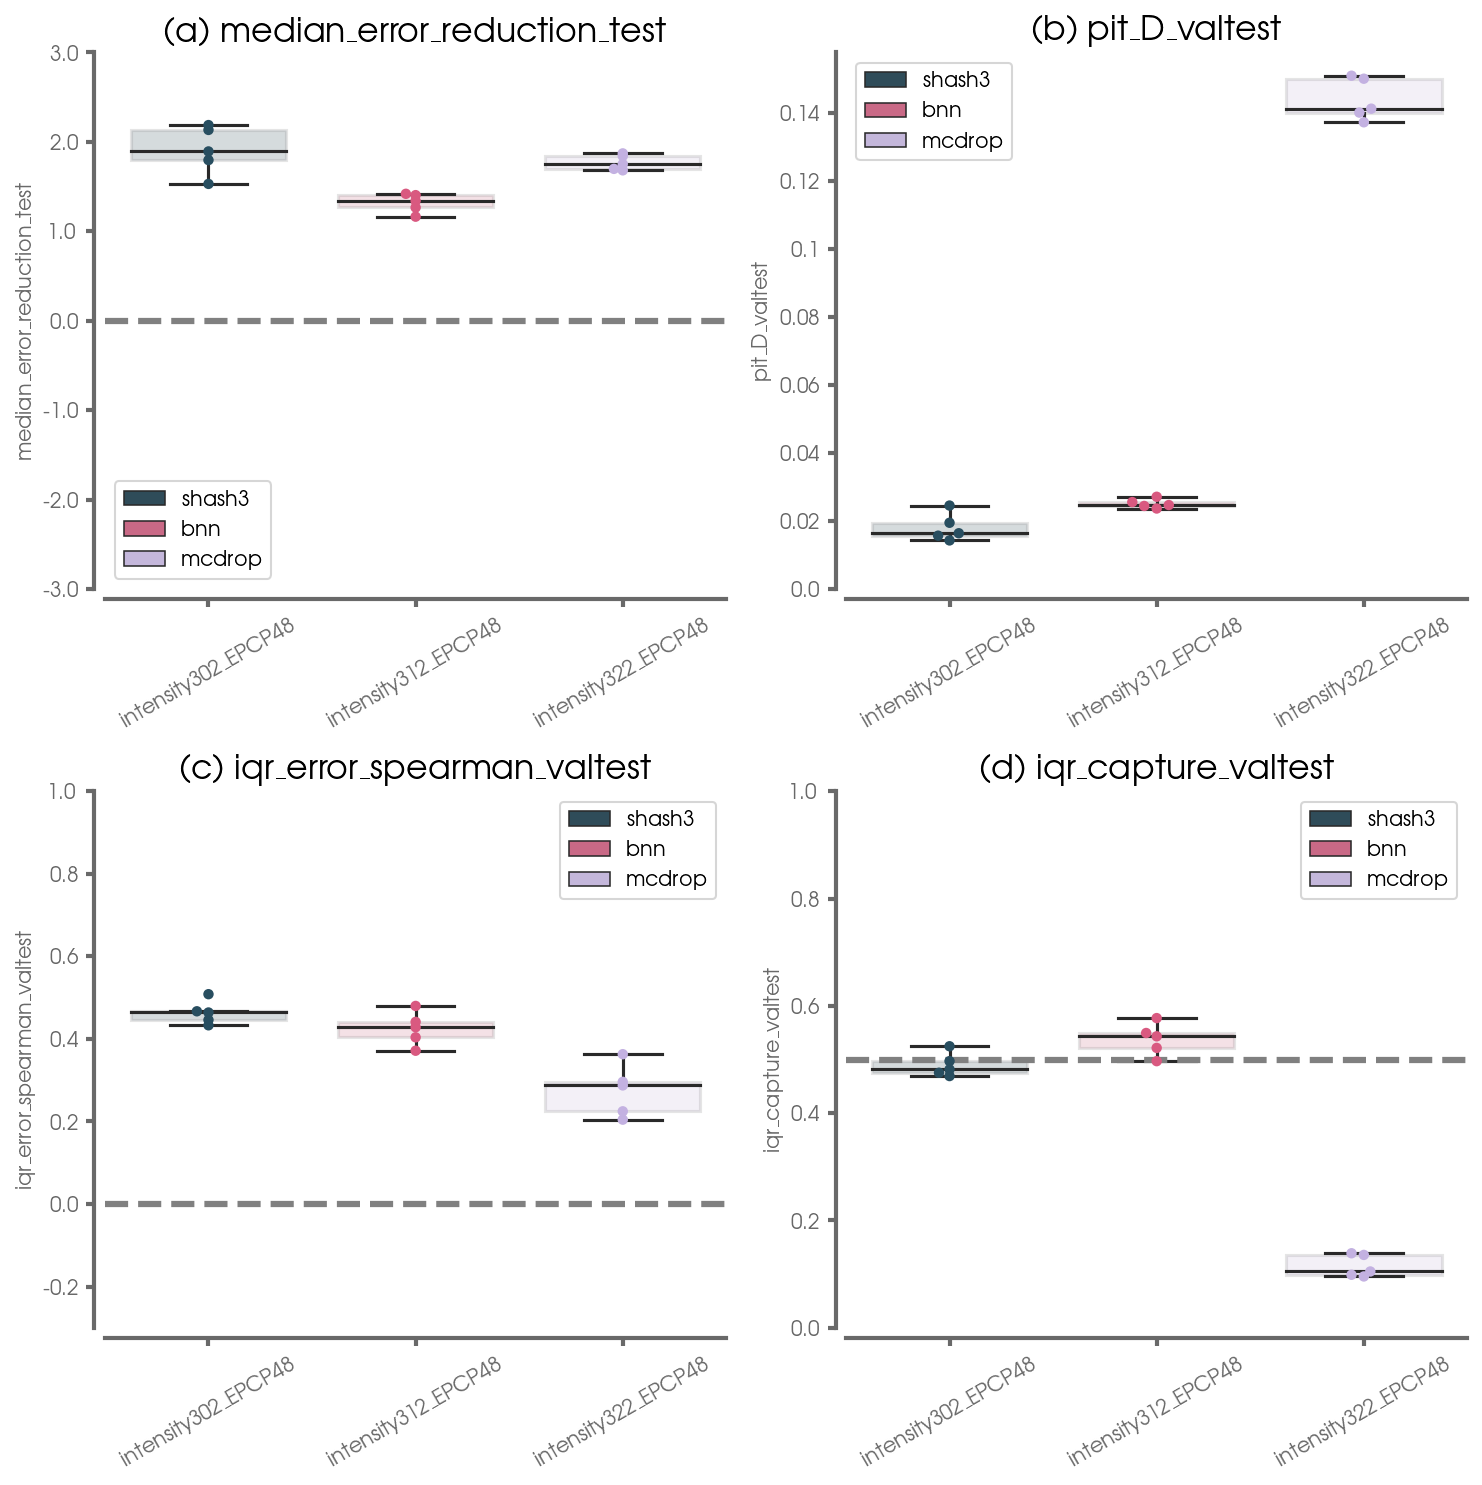

In [8]:
import seaborn as sns
colors = ('#284E60','#D95980','#C3B1E1')#('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("exp_name",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(10,10))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="uncertainty_type",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=False,                    
                         boxprops={'alpha':.2,
                                   'edgecolor': 'gray',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="uncertainty_type",
                           palette=colors,
                           data=df_metrics, 
                           size=5,
                           dodge=False,
                           ax=ax)
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:3], labels[:3],fontsize=10,frameon=True)
        
        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,None)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-3.,3.)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

        ax.set_title(panel_letters[imetric] + ' ' + metric + APPEND_NAME,
                     fontsize=FS,
                     color='k',
                    )
        # ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'uq_comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()

In [6]:
for exp_name in df_metrics["exp_name"].unique():
    df_show = df_metrics.loc[df_metrics["exp_name"]==exp_name][["exp_name",
                                                                "network_seed", 
                                                                "median_error_reduction_val",
                                                                "median_error_reduction_test",                                                                
                                                               ]]
    display(df_show)

,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity302_EPCP48,222,0.880464,1.796689
0,intensity302_EPCP48,333,2.237971,2.133845
0,intensity302_EPCP48,416,2.713906,1.893354
0,intensity302_EPCP48,599,2.011609,1.530219
0,intensity302_EPCP48,739,2.206326,2.188107


,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity312_EPCP48,222,0.862070,1.419559
0,intensity312_EPCP48,333,1.477509,1.404662
0,intensity312_EPCP48,416,1.545663,1.266438
0,intensity312_EPCP48,599,0.934375,1.340806
0,intensity312_EPCP48,739,1.353774,1.163913


,exp_name,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity322_EPCP48,222,1.109005,1.842367
0,intensity322_EPCP48,333,1.832968,1.871516
0,intensity322_EPCP48,416,1.650578,1.752274
0,intensity322_EPCP48,599,1.120561,1.698478
0,intensity322_EPCP48,739,1.552959,1.681936
